# Galaxy Selector MOC

**Compared to the "Simple Galaxy Selector, this works with Multi-Ordering-Sky-Maps**


***NOTE (this note may be wrong, just copied from old notebook)***: Before anything can happen, download the GW event localization map. Open the terminal and type:
"curl -O https://gracedb.ligo.org/api/superevents/sid/files/bayestar.fits,0"
with sid = superevent ID (could be incorporated into this notebook)

Select the galaxies to observe by WWFI in this simple manner:
- get the LIGO event data
- read the LIGO event data into the notebook, extract some information
- read the DESI database into the notebook, "clean" the data
- get the 99% credible regions for the event, add them as a column to the data
- only keep data within the 99% region
- calculate all the luminosities (& more)
- rank them by luminosity (for now just print the TARGETID), 3D/2D localization and with a luminosity-distance 2D dependant counterpart likelihood

Sources: 
- https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10
- https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html
- https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html
- https://arxiv.org/pdf/1710.05452.pdf

## Import all libraries, load GW data and DESI data and extract basic info

### imports, GW data loading

In [122]:
import numpy as np
from scipy.stats import norm
import scipy as sc

from astropy.io import fits, ascii
from astropy.table import Table, hstack
from astropy import table

import healpy as hp
import astropy_healpix as ah

from astropy.table import QTable

import psycopg2

from scipy.stats import norm


from astropy.cosmology import Planck18, z_at_value
from astropy.coordinates import Distance, SkyCoord
from astropy import units as u

import astropy.constants as asc

import matplotlib.pyplot as plt

import requests as rq

import gasel as gs

import shutil

In [123]:
# specify the superevent name:
superevent_name = "S230528a"

In [124]:
path = f"/global/homes/j/jgassert/ligo-desi-gw-follow-up/Galaxy Selection/Files/{superevent_name}bayestar.multiorder.fits,1"

try:
    skymap = QTable.read(path)
    print("read skymap from local file")
    
except:
    download_url = f"https://gracedb.ligo.org/api/superevents/{superevent_name}/files/bayestar.multiorder.fits,1"
    save_path = f"Files/{superevent_name}bayestar.multiorder.fits,1"
    print("no local skymap...")
    print(f"...will download LIGO event file from superevent {superevent_name}, corresponding file URL is {download_url} and save it in .../Files/")
    
    response = rq.get(download_url, allow_redirects = True)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            #response.raw.decode_content = True
            #shutil.copyfileobj(response.raw, f)
            f.write(response.content)
            
        skymap = QTable.read(path)

read skymap from local file


Specifiy the path where the data is located and then load the data (this loads everything, just have a look)

In [125]:
skymap[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1024,0.0005541929163871758,235.3674659569915,98.0130148801578,1.538735211517382e-05
1025,0.0003046347359318278,218.26812453682325,93.95339189355074,1.771500003765361e-05
1026,0.000555993638120194,240.36470275862726,100.59883499024933,1.4732349830887497e-05
1027,0.0002834069415847336,222.0373059447743,99.12097007757346,1.6920989500474807e-05
1028,0.0002695943074344819,201.72370608658338,85.4122455146413,2.084465666788782e-05


### Get basic values from GW event

We now extract some basic information  from the healpix data:
- ipix_max: pixel with highest likelihood
- npix: total number of pixels
- ra, dec: ra and dec of the pixel with the highest likelihood

Then we open the full fits file and extract some more basic info from the header:
- dist_mean: mean distance of the GW event
- dist_std: error of the distance

In [126]:
# most probable sky location
i = np.argmax(skymap["PROBDENSITY"])
uniq = skymap[i]["UNIQ"]
print("UNIQ ID of highest prob sky localization: ", uniq)

UNIQ ID of highest prob sky localization:  3638181


In [127]:
# calculate the most probable pixel, convert to RA and dec
level_max, ipix_max = ah.uniq_to_level_ipix(uniq)
nside = ah.level_to_nside(level_max)
ra, dec = ah.healpix_to_lonlat(ipix_max, nside, order = "nested")
print("Highest probability at (RA, dec): ", ra.deg, dec.deg, "with prob [1/deg^2] of: ", skymap[i]['PROBDENSITY'].to_value(u.deg**-2), "and UNIQ ID: ", skymap[i]["UNIQ"])

Highest probability at (RA, dec):  122.958984375 -25.94447977237001 with prob [1/deg^2] of:  0.0035846818362901506 and UNIQ ID:  3638181


Now open the fits file and read basics info from the header

In [128]:
fits_gw = fits.open(path)
header = fits_gw[1].header
dist_mean = header["DISTMEAN"]
dist_std = header["DISTSTD"]
print("The dist_mean and dist_std values: ", dist_mean*u.Mpc, dist_std*u.Mpc)

The dist_mean and dist_std values:  261.3212674699854 Mpc 107.6371751798119 Mpc


In [129]:
most_likely_z = z_at_value(Planck18.luminosity_distance, dist_mean*u.Mpc, zmax = 5)
most_likely_z_std = z_at_value(Planck18.luminosity_distance, dist_std*u.Mpc, zmax = 5)

In [130]:
most_likely_z, most_likely_z_std

(<Quantity 0.05657432 redshift>, <Quantity 0.02385994 redshift>)

In [131]:
# these values (924, 188Mpc) are close to z= 0.19, 0.03

### Get DESI data

Load the full daily data from the file, which only includes good redshift objects

In [132]:
follow_up_others = False

In [170]:
if follow_up_others:
    center_ra = 235.9839
    center_dec = 15.2248
    radius = 1/360
    z_others = 0
    z_others_std = 0.4
    
    sigma_accuracy = 3
    
    data = gs.db_doall(center_ra, center_dec, radius)
    
    #ii = data["Z"]-sigma_accuracy*data["ZERR"]<z_others+sigma_accuracy*z_others_std
    #ii &= data["Z"]+sigma_accuracy*data["ZERR"]>z_others-sigma_accuracy*z_others_std
    
    #data = data[ii]
    
    
else:
    desi_path = "/global/homes/j/jgassert/good_z_data.ecsv" #use a binary format -> faster
    raw_data = ascii.read(desi_path)

In [171]:
data = Table(raw_data, copy = True)

In [175]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64
6448025174016,179.15657,28.4234799,20210318,0.0221933367215889,9.68081653157043e-06,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
6521555517440,204.22749,32.09493,20210404,0.3238872170838,2.72909868562699e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
6536638234624,186.274119,32.84503,20210402,0.0764062738003505,1.47657330826664e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
45650485968998,132.7115638,11.7857382,20220130,6.60562456030607e-05,4.43577130671508e-06,0,0.0,0.0,0.0,STAR,0,0.0,0.0
45650490163336,132.9894508,11.7344802,20220130,0.000113703992211096,4.59116159557144e-06,0,0.0,0.0,0.0,STAR,0,0.0,0.0


## Do all the calculations, selections,...

- turn the daily DESI data into a Table
- do some basic data selection stuff: only keep good + positive redshifts, only positive values of z-band flux and eliminate duplicates (right now simply takes the first entry)
- add the ipix (healpix) pixel value for each target
- calculate the probability for each target
- add these values to the Table ("PROB"), select only targets within the 99% credible region (i.e. with a certainty of 99% the GW event is inside this region)
- calculate the distances and its errors from the redshift, add to the data table
- calculate the 3D probability just like here: https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10 (§4) and add these values to the table
- sort the table by its 3D probability (descending)
- calculate absolute and apparent magnitude, luminosity and add to table

The final step is to include the calculation of the most likely host galaxy from https://arxiv.org/pdf/1710.05452.pdf (GW170817); these values are then also added to the table as "P_GAL"

In [135]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64
-407206628,289.160148698913,63.8756777034092,20210513,0.488143245600312,6.00460085329576e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206517,289.24523373072,64.1182126208345,20210513,0.353953432359517,9.16563620937551e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206395,288.991137990503,64.4269390406163,20210513,1.04167986703249,0.000103598417102832,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206306,288.328820102558,64.8171915439228,20210513,0.446085744563991,0.000103302897346752,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206302,288.170414727353,64.8761951861955,20210513,5.11210896599966,0.000690663180059733,0,0.0,0.0,0.0,QSO,0,0.0,0.0


### data clean up

In [176]:
#data = data[data["Z"]> 0]
#data = data[data["ZWARN"] == 0]

In [177]:
#data = data[data['FLUX_Z']>0]
data = table.unique(data, keys = "TARGETID")

In [178]:
data = data[data["TARGETID"]>0]

In [179]:
print(f"We have {len(data)} objects in the full catalog") 

We have 27496796 objects in the full catalog


### Calculate the healpix id for every object in the catalog and its probability; append this data to the Table

In [180]:
max_level = 29 # highest possible HEALPix resolution that can be represented in a 64-bit signed integer
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])

index = ipix*(2**(max_level-level))**2

sorter = np.argsort(index)

# this is the NESTED pixel index of the target sky location, NOT THE UNIQ ID
match_ipix = ah.lonlat_to_healpix(data["TARGET_RA"]*u.deg, data["TARGET_DEC"]*u.deg, max_nside, order='nested')

# here we get the pixel index (i.e. where the entry is in the table, also NOT THE UNIQ ID) of each target
sorter_i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
probdensity = skymap[sorter_i]['PROBDENSITY'].to_value(u.deg**-2)

# now we calculate the UNIQ ID for all our targets:

uniq = skymap["UNIQ"][sorter_i]
#to make things easier in future, I will now also append the UNIQ pixels DISTMU, DISTSIGMA and DISTNORM values. However, be careful, since these DO NOT CORRESPOND THE TARGETS IN DESI DIRECTLY!

distmu = skymap[sorter_i]["DISTMU"]
distsigma = skymap[sorter_i]["DISTSIGMA"]
distnorm = skymap[sorter_i]["DISTNORM"]


In [181]:
# len(UNIQ), len(data), len(skymap)

In [182]:
#data = data.keep_columns(["TARGETID", "TARGET_RA", "TARGET_DEC", "TILEID", "NIGHT", "Z", "ZERR", "ZWARN", "DELTACHI2", "FLUX_Z", "BGS_TARGET", "EBV", "SERSIC", "MWS_TARGET", "FILENAME"])
                          

In [183]:
data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity}), Table({"DISTMU": distmu}), Table({"DISTSIGMA": distsigma}), Table({"DISTNORM": distnorm})])

In [184]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64
6448025174016,179.15657,28.4234799,20210318,0.0221933367215889,9.68081653157043e-06,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,2803,1.5495799740992574e-11,583.3803459690228,180.9578390019513,2.6804222008428616e-06
6521555517440,204.22749,32.09493,20210404,0.3238872170838,2.72909868562699e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,1676,1.2748150725396183e-12,628.6718317886678,173.64814186986004,2.3508312733231255e-06
6536638234624,186.274119,32.84503,20210402,0.0764062738003505,1.47657330826664e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,2807,1.1634977567992311e-11,605.2089781453952,174.53644712319684,2.5205430320177344e-06
45650485968998,132.7115638,11.7857382,20220130,6.60562456030607e-05,4.43577130671508e-06,0,0.0,0.0,0.0,STAR,0,0.0,0.0,5170,2.6069041996246284e-06,198.37635950670207,131.00292857520725,1.7813565068583708e-05
45650490163336,132.9894508,11.7344802,20220130,0.000113703992211096,4.59116159557144e-06,0,0.0,0.0,0.0,STAR,0,0.0,0.0,5170,2.6069041996246284e-06,198.37635950670207,131.00292857520725,1.7813565068583708e-05


In [185]:
print(f"The highest and lowest probability values in our catalog are: {np.min(probdensity)} and {np.max(probdensity)}")

The highest and lowest probability values in our catalog are: 1.008095954727654e-13 and 0.003471478883445694


### Sort the skymap table and get 99% credible region

In [186]:
# copy the table
skymap_sort = Table(skymap, copy = True)

In [187]:
# check whether copy worked:
# skymap_sort, skymap
# np.max(skymap["UNIQ"])

In [188]:
# now sort the skymap by its probability (descending)
skymap_sort.sort('PROBDENSITY', reverse=True)

In [189]:
# this shows the first entries sorted be their probability
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
3638181,11.767816294945064,155.32206037151465,43.65028800915164,3.841684426060163e-05
3638240,11.76299451569138,155.52132091131236,43.94043790090246,3.828836077836926e-05
3638262,11.761236845038502,156.63046603983588,44.24065668217826,3.7749677626549884e-05
3638193,11.760325200053979,155.33053363803884,43.739920783421795,3.840140739298237e-05
3638947,11.750580864965771,156.81776315167482,44.46995749299754,3.763736912601958e-05


In [190]:
# now get 99% credible region area

level, ipix = ah.uniq_to_level_ipix(skymap_sort['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # this is the area each pixel contains

# calculate the probability per pixel (careful: since the pixels differ in size, this is not neceseraliy a useful quantity
prob = pixel_area * skymap_sort['PROBDENSITY']

# calc cumsum of probabilities and get index of pixel that sums up to 0.99
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.99)

# print area
area_99 = pixel_area[:i].sum()
area_99.to_value(u.deg**2)

5143.191457854032

### can be deleted, just tried things out

In [191]:
skymap_sort = hstack([skymap_sort, Table({"PROB": prob})])

In [192]:
np.max(prob)

<Quantity 0.00014011>

In [193]:
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
3638181,11.767816294945064,155.32206037151465,43.65028800915164,3.841684426060163e-05,4.7009385707847175e-05
3638240,11.76299451569138,155.52132091131236,43.94043790090246,3.828836077836926e-05,4.699012394550713e-05
3638262,11.761236845038502,156.63046603983588,44.24065668217826,3.7749677626549884e-05,4.698310250536925e-05
3638193,11.760325200053979,155.33053363803884,43.739920783421795,3.840140739298237e-05,4.697946071919313e-05
3638947,11.750580864965771,156.81776315167482,44.46995749299754,3.763736912601958e-05,4.694053461810972e-05


In [194]:
skymap_prob = Table(skymap_sort, copy = True)

In [195]:
skymap_prob.sort("PROB", reverse = True)

In [196]:
skymap_prob[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
202926,2.1920481519214716,294.07021512005593,92.92058388364882,1.051407615925876e-05,0.00014010665629865678
914138,8.766115581599957,183.98329005846008,57.08901301014159,2.694784023993414e-05,0.00014007346756832602
28471,0.5478774928549901,212.45317805674532,113.88210335151567,1.724282975855822e-05,0.00014007225802575122
82177,2.191423349027959,249.76684558785897,85.81789201144677,1.4337719820865754e-05,0.00014006672148053745
898248,8.764037472177876,146.3550975952474,43.216095554189316,4.294174654801256e-05,0.0001400402615274031


### Compare Tables, only leave 99% credible region in DESI data table

Now we can get a Table that only contains the 99% credible region. From there we only leave the matching objects in the DESI data

In [197]:
# we simply select only the entries that are within the 99% credible region
skymap_99 = skymap_sort[:i]

In [198]:
print("This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID):", len(np.intersect1d(skymap_99["UNIQ"], data["UNIQ"])))

This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID): 5272


In [199]:
mask = np.in1d(data["UNIQ"], skymap_99["UNIQ"])
data_99 = data[mask]

In [200]:
print(f"We now have {len(data_99)} objects in the 99% credible region")
print("Check if the region from where the galaxies have been selected makes any sense (RA; DEC): ", np.min(data_99["TARGET_RA"]), np.max(data_99["TARGET_RA"]), np.min(data_99["TARGET_DEC"]), np.max(data_99["TARGET_DEC"]))

max_probdens_in_desi = np.max(data_99["PROBDENSITY"])
max_probdens_in_ligo = np.max(skymap["PROBDENSITY"]).to_value(u.deg**-2)
print(f"We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...")
print(f"This is {np.allclose(max_probdens_in_desi, max_probdens_in_ligo)}")

We now have 3927769 objects in the 99% credible region
Check if the region from where the galaxies have been selected makes any sense (RA; DEC):  1.84754109952898e-06 359.999979958843 -21.9984297720973 81.191800114061
We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...
This is False


In [201]:
data_99.sort('PROBDENSITY', reverse=True)

In [202]:
data_99[:2]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64
2305843051727191261,126.611592967165,-21.4859902526539,20230329,0.000132821506173356,7.53989286659552e-06,0,-99.0,-99.0,-99.0,STAR,0,0.106073938310146,0.0,3643407,0.003471478883445694,163.55433747997935,46.913914844256055,3.4541274429056404e-05
2305843051727201987,126.57764961045,-21.4702568941703,20230329,0.000234017376068832,2.53411176599696e-06,0,-99.0,-99.0,-99.0,STAR,0,0.106560289859772,0.0,3643407,0.003471478883445694,163.55433747997935,46.913914844256055,3.4541274429056404e-05


In [203]:
print("We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky")
min_z = np.min(data_99["Z"])
max_z = np.max(data_99["Z"])
print(f"However, we have not used the distance data at all. Therefore our redhsifts range from {min_z} to {max_z}")

We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky
However, we have not used the distance data at all. Therefore our redhsifts range from 3.41128153223822e-10 to 6.87419687041459


### Calculate all the distances of the objects from the redshifts

In [204]:
distances = Distance(z=data_99["Z"], cosmology=Planck18)
distances_err = Distance(z=data_99["ZERR"], cosmology=Planck18)

data_99 = hstack([data_99, Table({"DIST_Z": distances}), Table({"DIST_Z_ERR": distances_err})])

In [205]:
data_99[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64
2305843051727191261,126.611592967165,-21.4859902526539,20230329,0.000132821506173356,7.53989286659552e-06,0,-99.0,-99.0,-99.0,STAR,0,0.106073938310146,0.0,3643407,0.003471478883445694,163.55433747997935,46.913914844256055,3.4541274429056404e-05,0.5885743436397801,0.03340845523302355
2305843051727201987,126.57764961045,-21.4702568941703,20230329,0.000234017376068832,2.53411176599696e-06,0,-99.0,-99.0,-99.0,STAR,0,0.106560289859772,0.0,3643407,0.003471478883445694,163.55433747997935,46.913914844256055,3.4541274429056404e-05,1.037085863104444,0.011228333890753108
2305843051727202513,126.587485436351,-21.4348626234004,20230329,2.21943919725311e-05,4.61698692951945e-07,0,-99.0,-99.0,-99.0,STAR,0,0.107814282178879,0.0,3643407,0.003471478883445694,163.55433747997935,46.913914844256055,3.4541274429056404e-05,0.09834207112418376,0.002045726204645667
2305843051727203575,126.561481061874,-21.4108183153728,20230329,2.39324046875555e-05,9.36170931389996e-07,0,-99.0,-99.0,-99.0,STAR,0,0.109336204826832,0.0,3643407,0.003471478883445694,163.55433747997935,46.913914844256055,3.4541274429056404e-05,0.1060432465380262,0.004148051818683516
2305843051727207574,126.722253219735,-21.3354056684836,20230329,6.31869958719784e-05,2.14002228047877e-06,0,-99.0,-99.0,-99.0,STAR,0,0.111450895667076,0.0,3643419,0.003457537436661609,163.58158635093432,47.1219123163848,3.450734199555327e-05,0.2799867334450579,0.009482169556146607


### Lets check how much the distance measurement changes in the 99% credible region of LIGO and compare to our DESI data

We should see a lot more data in DESI (since we haven't done any redshift selection and there can be multiple objects per GW-pixel). Be carfeul, we are comparing actual object counts with the number of pixels.


We still see, that most of the GW localization is roughly between 780Mpc and 950Mpc. DESI definitely has a most of its data in this range as well.

Our distance ranges from -17822.23272954102 Mpc to inf Mpc
Let's visualize the distance distribution of the LIGO event in the 99% credible region


ValueError: supplied range of [-17822.23272954102, inf] is not finite

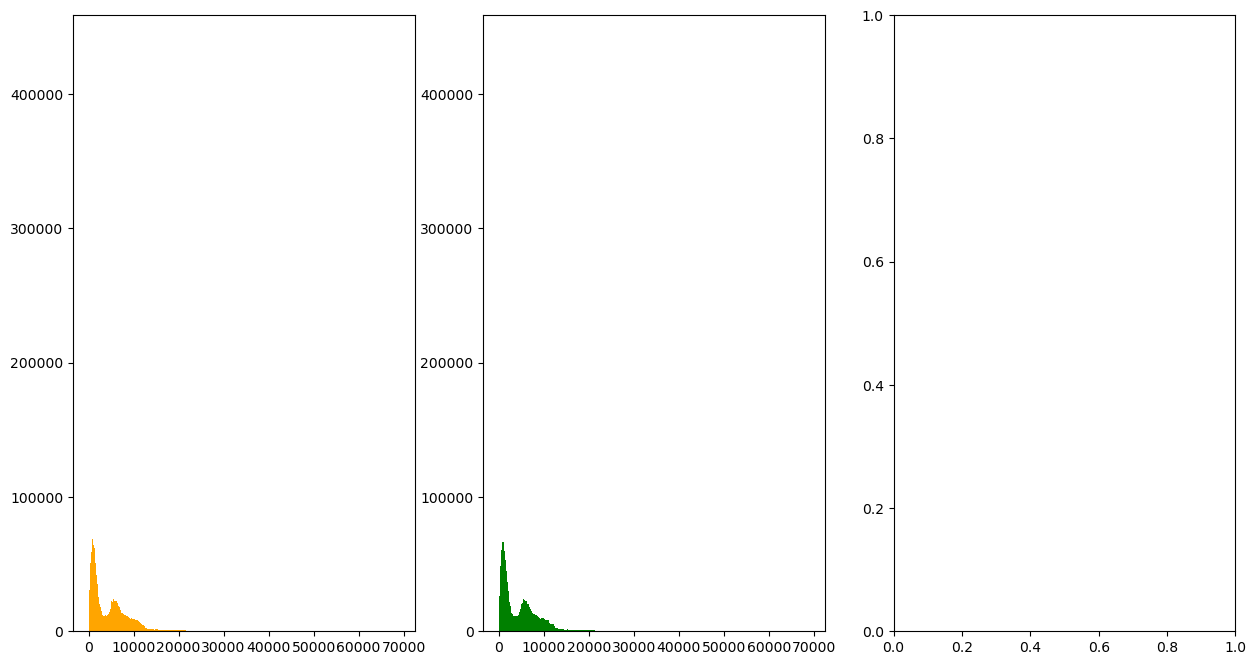

In [206]:
dist_max_99 = np.max(skymap_99["DISTMU"])*u.Mpc
dist_min_99 = np.min(skymap_99["DISTMU"])*u.Mpc
print(f"Our distance ranges from {dist_min_99} to {dist_max_99}")
print("Let's visualize the distance distribution of the LIGO event in the 99% credible region")

fig, ax = plt.subplots(ncols = 3, figsize = (15,8))


ax[0].hist(data_99["DIST_Z"], bins = "auto", color = "orange")
ax[1].hist(data_99["DIST_Z"], bins = "auto", color = "green")
ax[2].hist(skymap_99["DISTMU"], bins = "auto", color = "blue")


for axis in ax:
    axis.set_xlabel("distance bin (Mpc)")

ax[0].set_ylabel("object count")
ax[1].set_ylabel("object count")
ax[2].set_ylabel("pixel count")

ax[1].set_xlim(0,1000)
    
plt.show()

In [ ]:
len(skymap_99), len(data_99)

### To reduce our data even more, lets cut out the unreasonably far away objects

We simply take maximum and minimum distance we get from the LIGO skymap (i.e. DISTMU+-DISTERR) and check, whether every galaxy in that pixel falls inside this range.

*Note: We do this only for our own GW-follow ups*

In [207]:
if follow_up_others == False:
    z_selection_mask = data_99["DIST_Z"] - data_99["DIST_Z_ERR"] <  data_99["DISTMU"] + data_99["DISTSIGMA"]
    z_selection_mask &= data_99["DIST_Z"] + data_99["DIST_Z_ERR"] >  data_99["DISTMU"] - data_99["DISTSIGMA"]

    data_99_z = data_99[z_selection_mask]

    remaining_obj = np.size(np.where(z_selection_mask == True))
    deleted_obj = np.size(np.where(z_selection_mask == False))

    print(f"The z-range selection has deleted {deleted_obj} objects from originally {deleted_obj+remaining_obj} in the data set")
    print(f"Therefore, we have {remaining_obj} objects left in the search region")

    highest_prob_dens = np.max(data_99_z["PROBDENSITY"])
    print(f"Our highest remaing probability density is {highest_prob_dens} compared to the originally highest prob density of {max_probdens_in_ligo}")
    print(f"The difference in prob density is {max_probdens_in_ligo-highest_prob_dens}")

    
else:
    data_99_z = data_99
    remaining_obj = len(data_99_z)

The z-range selection has deleted 3813601 objects from originally 3927769 in the data set
Therefore, we have 114168 objects left in the search region
Our highest remaing probability density is 0.0020119910361893504 compared to the originally highest prob density of 0.0035846818362901506
The difference in prob density is 0.0015726908001008001


In [208]:
data_99_z[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64
39627612200374037,135.602198144495,-7.34156655447563,20211215,0.046132817837568,8.02344434126188e-06,0,74.9669036865234,44.463550567627,105.81322479248,GALAXY,131074,0.0346241630613804,1.49737846851349,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,211.51601010868498,0.03555103304477909
39627612200374214,135.609426226768,-7.29091063939034,20211215,0.0461578815501072,1.46803233402624e-05,0,263.676818847656,112.763641357422,491.254272460938,GALAXY,131074,0.0330447442829609,3.81842470169067,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,211.63472339229784,0.06504729157919356
39627612204567663,135.813386597477,-7.3730199449854,20211215,0.0544163710740239,1.26883810801372e-05,0,17.9206809997559,10.9724283218384,24.2143650054932,GALAXY,131074,0.0458050668239594,1.0,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,250.97073252977495,0.05622107526785652
39627600213052089,135.740340829945,-7.65569718378964,20211215,0.030978905271865,1.55978191213658e-06,0,315.660827636719,164.879257202148,519.712890625,GALAXY,131074,0.0419930629432201,1.64417743682861,916576,0.0019957596320158352,200.14206841129536,66.25417086615533,2.2499396259248077e-05,140.48643386673282,0.006911194391512129
39627606206711458,135.763708365514,-7.61292669456251,20211215,0.0532108654457551,6.52317937562897e-06,0,224.103164672852,137.242919921875,308.122161865234,GALAXY,131074,0.0433824062347412,1.41940438747406,916576,0.0019957596320158352,200.14206841129536,66.25417086615533,2.2499396259248077e-05,245.20151946970728,0.028903484458627282


### get the apparent, absolute magnitudes and luminosities

in order to do this: flux > 0 selection  and gal ext correction

In [209]:
# get the apparent mags
data_99_z = data_99_z[data_99_z["FLUX_Z"] > 0] # flux selection (only ones above 0)
data_99_z["MW_TRANSMISSION"] = gs.mw_transmission_from_data_table(data_99_z, "z")
#data_99_z["FLUX_Z"] = data_99_z["FLUX_Z"]/data_99_z["MW_TRANSMISSION"]

app_mag_z = gs.app_mag(data_99_z["FLUX_Z"])
flux_selection_cut = len(data_99_z)
print(f"We have {flux_selection_cut} objects remaining in our catalog, i.e. {remaining_obj-flux_selection_cut} had to be cut out due to bad fluxes")

# get the absolute mags
abs_mag_z = gs.abs_mag(app_mag_z, data_99_z["Z"], 0,0,0)

# get the luminosities
lums_z = gs.lum(abs_mag_z, band = "z")

We have 99944 objects remaining in our catalog, i.e. 14224 had to be cut out due to bad fluxes


In [210]:
data_f = hstack([data_99_z, Table({"APP_MAG_Z": app_mag_z}), Table({"ABS_MAG_Z": abs_mag_z}), Table({"LUM_Z": lums_z})])

In [211]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR,MW_TRANSMISSION,APP_MAG_Z,ABS_MAG_Z,LUM_Z
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,,,,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39627612200374037,135.602198144495,-7.34156655447563,20211215,0.046132817837568,8.02344434126188e-06,0,74.9669036865234,44.463550567627,105.81322479248,GALAXY,131074,0.0346241630613804,1.49737846851349,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,211.51601010868498,0.03555103304477909,0.9621173699376419,17.438650124337432,-19.188066103927145,5.503868608329986e+35
39627612200374214,135.609426226768,-7.29091063939034,20211215,0.0461578815501072,1.46803233402624e-05,0,263.676818847656,112.763641357422,491.254272460938,GALAXY,131074,0.0330447442829609,3.81842470169067,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,211.63472339229784,0.06504729157919356,0.9638137679979156,15.771734148802661,-20.856200475680392,2.5581252610783148e+36
39627612204567663,135.813386597477,-7.3730199449854,20211215,0.0544163710740239,1.26883810801372e-05,0,17.9206809997559,10.9724283218384,24.2143650054932,GALAXY,131074,0.0458050668239594,1.0,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,250.97073252977495,0.05622107526785652,0.9501934352831137,19.039817288381954,-17.958298103048506,1.77321279857569e+35
39627600213052089,135.740340829945,-7.65569718378964,20211215,0.030978905271865,1.55978191213658e-06,0,315.660827636719,164.879257202148,519.712890625,GALAXY,131074,0.0419930629432201,1.64417743682861,916576,0.0019957596320158352,200.14206841129536,66.25417086615533,2.2499396259248077e-05,140.48643386673282,0.006911194391512129,0.9542420717014579,15.710591277704847,-20.02758066445165,1.1925425449907768e+36
39627606206711458,135.763708365514,-7.61292669456251,20211215,0.0532108654457551,6.52317937562897e-06,0,224.103164672852,137.242919921875,308.122161865234,GALAXY,131074,0.0433824062347412,1.41940438747406,916576,0.0019957596320158352,200.14206841129536,66.25417086615533,2.2499396259248077e-05,245.20151946970728,0.028903484458627282,0.9527644900262393,16.278192659192737,-20.669423126304746,2.1538272462976473e+36


In [212]:
# np.max(data_f["MW_TRANSMISSION"])

In [213]:
max_lum_z = np.max(data_f["LUM_Z"])*u.W
prob_dens_max_lum = data_f[data_f["LUM_Z"] == max_lum_z]["PROBDENSITY"]
print(f"The maximum luminosity in our cataloge in the z-band is {max_lum_z} with a prob density of {prob_dens_max_lum}")

The maximum luminosity in our cataloge in the z-band is 1.1020414659957398e+38 W with a prob density of      PROBDENSITY     
---------------------
0.0001173313451804674


In [214]:
arg_errfc = abs(data_f["DIST_Z"]-data_f["DISTMU"])/(data_f["DIST_Z_ERR"]**2+data_f["DISTSIGMA"]**2)
P_gal_unnorm = data_f["LUM_Z"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc))
#dist_mean*u.Mpc, dist_std*u.Mpc
arg_errfc_c = abs(data_f["DIST_Z"].value-dist_mean)/(data_f["DIST_Z_ERR"].value**2+dist_std**2)
P_gal_unnorm_const = data_f["LUM_Z"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc_c))

# now lets quickly normalize

P_gal_sum = np.sum(P_gal_unnorm)
P_gal_const_sum = np.sum(P_gal_unnorm_const)

P_gal = 1/P_gal_sum * P_gal_unnorm
P_gal_const = 1/P_gal_const_sum * P_gal_unnorm_const

In [215]:
data_f = hstack([data_f, Table({"P_GAL": P_gal.value}), Table({"P_GAL_C": P_gal_const.value})])

In [216]:
data_f[:]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR,MW_TRANSMISSION,APP_MAG_Z,ABS_MAG_Z,LUM_Z,P_GAL,P_GAL_C
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,,,,W,,
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39627612200374037,135.602198144495,-7.34156655447563,20211215,0.046132817837568,8.02344434126188e-06,0,74.9669036865234,44.463550567627,105.81322479248,GALAXY,131074,0.0346241630613804,1.49737846851349,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,211.51601010868498,0.03555103304477909,0.9621173699376419,17.438650124337432,-19.188066103927145,5.503868608329986e+35,8.100993235055147e-05,8.084353182555473e-05
39627612200374214,135.609426226768,-7.29091063939034,20211215,0.0461578815501072,1.46803233402624e-05,0,263.676818847656,112.763641357422,491.254272460938,GALAXY,131074,0.0330447442829609,3.81842470169067,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,211.63472339229784,0.06504729157919356,0.9638137679979156,15.771734148802661,-20.856200475680392,2.5581252610783148e+36,0.00037651183255837516,0.00037575439865693
39627612204567663,135.813386597477,-7.3730199449854,20211215,0.0544163710740239,1.26883810801372e-05,0,17.9206809997559,10.9724283218384,24.2143650054932,GALAXY,131074,0.0458050668239594,1.0,916579,0.0020119910361893504,202.49365700670614,65.9925473520847,2.2046820811211038e-05,250.97073252977495,0.05622107526785652,0.9501934352831137,19.039817288381954,-17.958298103048506,1.77321279857569e+35,2.583201548953095e-05,2.6146394317311716e-05
39627600213052089,135.740340829945,-7.65569718378964,20211215,0.030978905271865,1.55978191213658e-06,0,315.660827636719,164.879257202148,519.712890625,GALAXY,131074,0.0419930629432201,1.64417743682861,916576,0.0019957596320158352,200.14206841129536,66.25417086615533,2.2499396259248077e-05,140.48643386673282,0.006911194391512129,0.9542420717014579,15.710591277704847,-20.02758066445165,1.1925425449907768e+36,0.00017184293819245256,0.00017254560771425877
39627606206711458,135.763708365514,-7.61292669456251,20211215,0.0532108654457551,6.52317937562897e-06,0,224.103164672852,137.242919921875,308.122161865234,GALAXY,131074,0.0433824062347412,1.41940438747406,916576,0.0019957596320158352,200.14206841129536,66.25417086615533,2.2499396259248077e-05,245.20151946970728,0.028903484458627282,0.9527644900262393,16.278192659192737,-20.669423126304746,2.1538272462976473e+36,0.0003115445526365616,0.00031484708027294404
39627600213050384,135.669591994032,-7.66278178072034,20220327,0.0457676404032076,5.21695089445424e-06,0,21.5294532775879,16.1210289001465,24.5543193817139,GALAXY,131074,0.042968425899744,0.5,916576,0.0019957596320158352,200.14206841129536,66.25417086615533,2.2499396259248077e-05,209.78682142659147,0.02311570775882,0.9532045231475967,19.02468024880779,-17.584210765296994,1.2563941979722635e+35,1.834073334218452e-05,1.8302559758471832e-05
39627618198228884,135.624011433451,-7.10583642242373,20211215,0.0450319050361274,1.14338923227286e-05,0,471.210479736328,203.261520385742,865.733276367188,GALAXY,131074,0.0328835621476173,5.23309993743896,916588,0.0019907977921400453,204.74577281016494,65.82628068835403,2.1620054939850815e-05,206.3055808362031,0.05066249970113568,0.963987056158958,15.156539722739923,-21.41601515909347,4.283982417146087e+36,0.0006251136578122134,0.000622306726437706
39627612200372473,135.539410759258,-7.27026876184031,20211215,0.0457076365540045,4.42711268424076e-06,0,38.204948425293,28.2276725769043,45.3714981079102,GALAXY,131074,0.0315514393150806,0.773450255393982,916585,0.0019898008376906112,205.0603536052949,65.32469056478217,2.1590553058658506e-05,209.50277344866166,0.019616013861466962,0.9654204250610442,18.35804220164

## Analyse the data: How much luminosity do we cover? Which galaxies should we observe?

Lets look into what information we can retrieve from here. First we define, how many galaxies we could observe (N_galaxies).

We then calculate the luminosity (lum) from all the galaxies in this area, i.e. the total luminosity. From there do some comparison between the covered luminosity and total luminosity depending on the ranking by probability:
- simple "Maximum lum that could be covered" by looking at the brightest galaxies
- Calculate the probability this way (from https://arxiv.org/pdf/1710.05452.pdf w/o normalization), both using a static and variable distance and error: $$P_{gal} = k^{-1}\tilde{L_z}(1-f_{missed})\cdot P_{2D}\left(1-\text{erf}\left(\frac{|D_{Gal}-D_{LVC}|}{\sigma_{D,gal}^{2}+\sigma_{D,LVC}^{2}+\sigma_{D,cosmology}^{2}}\right)\right)$$
- others may follow...

Since we have the actual luminosity (here in z-band though), we don't need to again calculate the $$\tilde{L}_{gal}$$ values. In the mentioned paper, they only use a fixed distance and error for the LIGO data. I will try both, to get an idea what the differences are.

In [217]:
N_galaxies = 20 # how many galaxies we can cover

In [218]:
total_lum = np.sum(data_f["LUM_Z"])

### Compare lum with luminosity ranking

https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10

In [219]:
data_sort_by_lums = data_f.group_by("LUM_Z")
data_sort_by_lums = data_sort_by_lums[::-1]

In [220]:
lum_after_N_highest = np.sum(data_sort_by_lums["LUM_Z"][:N_galaxies])

In [221]:
print(f"The theoretical maximum luminosity we could cover is {lum_after_N_highest}, i.e. {lum_after_N_highest*100/total_lum} % of the total luminosity")
print("The TARGETID values of these galaxies are: \n", data_sort_by_lums["TARGETID"][:N_galaxies])

The theoretical maximum luminosity we could cover is 1.1846804988374095e+39, i.e. 0.6957317570129208 % of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID    
-----------------
39627682027145294
39627754651517146
39627550644773112
39627785064419018
39627929709187075
39627380100171394
39627971375399776
39627724473500756
39627839045111841
39628143262173439
39627670304068675
39633519844002219
39627414929673266
39627724607722506
39627772888358238
39627748481700252
39627815007559736
39633358673674448
39627845315595984
39627479551315360


### Compare lum with P_Gal ranking

In [222]:
data_sort_by_PGal = data_f.group_by("P_GAL")
data_sort_by_PGal = data_sort_by_PGal[::-1]

lum_after_N_PGal = np.sum(data_sort_by_PGal["LUM_Z"][:N_galaxies])

In [223]:
print(f"The maximum luminosity we cover when ranked by P_gal is {lum_after_N_PGal}, i.e. {lum_after_N_PGal*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal is 5.004633632095994e+38, i.e. 0.2939089951662967% of the total luminosity
The TARGETID values of these galaxies are: 
    TARGET_RA         TARGET_DEC     ...      TARGETID             P_GAL        
---------------- ------------------ ... ----------------- ---------------------
135.306339723022  -6.06669049317723 ... 39627642214814637 0.0033620310728259143
 136.13119697614  -7.34989525008305 ... 39627612208764092 0.0025674079565165837
 138.77627421922 -0.718401048599523 ... 39627768937317120 0.0021666213991166595
141.923615281851   3.99420367287905 ... 39627883714450288 0.0021520748624891143
 138.91547799639  -1.34711618851211 ... 39627756857724320  0.001998273525976603
139.746230787757 -0.216432601180244 ... 39627781029499947 0.0019038452476926053
139.038087687048  0.296529762827997 ... 39627793100702526 0.0015734904519030212
345.225012061212   7.10310344860248 ... 39627959308387821 0.0015322735770678076
137.096161662303  -1.611444

In [224]:
data_sort_by_PGal_C = data_f.group_by("P_GAL_C")
data_sort_by_PGal_C = data_sort_by_PGal_C[::-1]

lum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_Z"][:N_galaxies])

In [225]:
print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal_C is 4.830091068109971e+38, i.e. 0.28365856858843824% of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID             P_GAL        
----------------- ---------------------
39627642214814637 0.0033620310728259143
39627612208764092 0.0025674079565165837
39627768937317120 0.0021666213991166595
39627883714450288 0.0021520748624891143
39627756857724320  0.001998273525976603
39627781029499947 0.0019038452476926053
39627793100702526 0.0015734904519030212
39627959308387821 0.0015322735770678076
39627750788565174 0.0014873187903957008
39627606215102513 0.0014657103925764699
39627732698533437  0.001317038254596253
39627953302145019 0.0012384892012258183
39627738742525633 0.0012157154172178625
39627748351680169 0.0012215284362066701
39627630198133820 0.0012191780444741646
39627793104897969  0.001185780505592604
39627736276275175 0.0011833766625799302
39627971304096885  0.001148590426531452
39627923296096345  0.001

In [226]:
data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "Z", "P_GAL"][:N_galaxies].write(f'PGAl_{superevent_name}.ecsv', delimiter=',', format='ascii', overwrite = False)

In [227]:
# add timing data to table, 